## Download and Install the libraries

In [1]:

#transformers
!pip install transformers
!pip3 install fasttext

zsh:1: command not found: pip
Defaulting to user installation because normal site-packages is not writeable


#### Import all the required libraries

In [2]:
import pandas as pd
import zipfile
import re
import csv
import urllib.request
import numpy as np
import seaborn as sns
import nltk 
import string

In [3]:
# import sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Data and preprocess


#### Import the annotated csv file

In [4]:
#zf = zipfile.ZipFile('/content/drive/MyDrive/CS521/Twitter_ethereum_annotated.zip') 
#df = pd.read_csv(zf.open('admin.csv'))

df = pd.read_csv('twitter_ethereum_annotated_all.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2754 entries, 0 to 2753
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2754 non-null   int64 
 1   data    2754 non-null   object
 2   label   2754 non-null   object
 3   date    2754 non-null   object
 4   user    2754 non-null   object
dtypes: int64(1), object(4)
memory usage: 107.7+ KB


In [7]:
#Explore data and create new columns after removing NANs
df["len_post"] = df["data"].apply(lambda line:len(str(line)))
df["body"] = df["data"].apply(lambda line : line if type(line) == str else np.nan )

In [8]:
# Fucntion to remove gibberish text
%%time

def replace_gibberish(text):
  "Replaces the text with more than certain word length and wrong spelling in English"
  lst = []
  for word in text.split():
    if len(word) >= 20:
      continue
    else:
      lst.append(word)
    
  return " ".join(lst)



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [9]:
# Expand all the contracted words in the tweets
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [10]:
#function used for preprocessing
def clean_text(text, rmstop = False):
  """
  Input : The text or sentence/s to be cleaned and if stopwords has to be removed or not
  --> text : string
  --> rmstop : bool
  Cleans the text by 
  # - Converting text to lowercase,
  - Mapping contracts to full text,
  - Remove text in paranthesis,
  - Remove specific special characters
  - Remove newline character
  Output : Cleand text or sentence/s
  """
 
  txt = re.sub('[0-9\n]','',text)
  txt = txt.replace("&gt", "")
  txt = re.sub(r"http\S+", "", txt)
  txt = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in txt.split(" ")])
  txt = re.sub(r'[^\w\s]', '',txt)
  txt = re.sub(r'\([^)]*\)', '', txt)
  txt = re.sub('"', '', txt)
  txt = txt.replace("\\", "")
  txt = re.sub(r"'s\b","",txt)
  txt = txt.rstrip().lstrip();
  nltk_sw = set(nltk_stopwords).union(stopwords)
  if rmstop:
    tokens = [word for word in txt.split() if not word in set(nltk_sw)]
  else:
    tokens = txt.split()
  
  return (" ".join(tokens)).strip()

In [11]:
# Run function to remove gibberish
%%time
df["body"] = df["body"].apply(lambda subject : replace_gibberish(subject))


CPU times: user 28.4 ms, sys: 1.92 ms, total: 30.4 ms
Wall time: 29 ms


In [12]:
# Download English stopwords using NLTK
nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prakash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#create list of punctuations and stopwords
punctuations = list(string.punctuation)
stopwords = set(nltk_stopwords).union(punctuations)

In [14]:
# Apply preprocessing function on all the tweets
%%time
df["body"] = df["body"].apply(lambda text : clean_text(text))

CPU times: user 130 ms, sys: 2.01 ms, total: 132 ms
Wall time: 131 ms


In [15]:
# Count of all the sentiments available in the dataset
df.label.value_counts()

Positive    1180
Neutral     1088
Negative     486
Name: label, dtype: int64

In [16]:
#Create a column to hold the train, test type
df['data_type'] = ['not_set'] * df.shape[0]
df

,id,data,label,date,user,len_post,body,data_type
0,1495720307264524290,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,Neutral,2022-02-21 11:21:25+00:00,cz_binance,55,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,not_set
1,1458947419874512903,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,Neutral,2021-11-11 23:59:05+00:00,cz_binance,145,KraZeMike mattysats _CryptoCurator ger Twitter...,not_set
2,1424032590504230913,» Binance Smart Chain Beats Ethereum by Some M...,Negative,2021-08-07 15:40:01+00:00,cz_binance,119,Binance Smart Chain Beats Ethereum by Some Met...,not_set
3,1421326936194703364,#BinanceSmartChain handled 10M+ transactions y...,Neutral,2021-07-31 04:28:43+00:00,cz_binance,80,BinanceSmartChain handled M transactions yeste...,not_set
4,1419504848047804416,2 years ago.\n\n» Binance CEO Predicts Amazon ...,Neutral,2021-07-26 03:48:23+00:00,cz_binance,119,years ago Binance CEO Predicts Amazon Coin Com...,not_set
...,...,...,...,...,...,...,...,...
2749,1230133891391868928,Govt lawyers are seldom concerned for the shar...,Negative,2020-02-19 14:15:49+00:00,rogerkver,203,Govt lawyers are seldom concerned for the shar...,not_set
2750,1206358584050610176,Don't like something? Don't buy it.\nHave som...,Neutral,2019-12-15 23:41:14+00:00,rogerkver,230,Dont like something Dont buy it Have something...,not_set
2751,1090981547144994816,This is the kind of attitude everyone should h...,Positive,2019-01-31 14:34:04+00:00,rogerkver,173,This is the kind of attitude everyone should h...,not_set
2752,980204762044878848,"#BTC a year ago 300k txs, now 170k\n#LTC a yea...",Neutral,2018-03-31 22:06:41+00:00,rogerkver,302,BTC a year ago k txs now k LTC a year ago k tx...,not_set


In [17]:
#Create a dataframe to hold only the labelled texts
df_labelled = df[df['label'].notnull()]

In [18]:
#Count of each sentiment in the lablled dataset
df_labelled.label.value_counts()

Positive    1180
Neutral     1088
Negative     486
Name: label, dtype: int64

In [19]:
#get unique values
possible_labels = df_labelled.label.unique()
possible_labels

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [20]:
#Create label dictionary and assign int values to the labels
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [21]:
label_dict

{'Neutral': 0, 'Negative': 1, 'Positive': 2}

In [22]:
#Replace label text with label code using the label_dict mapping
df['label_code'] = df.label.replace(label_dict)
df_labelled['label_code'] = df_labelled.label.replace(label_dict)
df_labelled

,id,data,label,date,user,len_post,body,data_type,label_code
0,1495720307264524290,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,Neutral,2022-02-21 11:21:25+00:00,cz_binance,55,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,not_set,0
1,1458947419874512903,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,Neutral,2021-11-11 23:59:05+00:00,cz_binance,145,KraZeMike mattysats _CryptoCurator ger Twitter...,not_set,0
2,1424032590504230913,» Binance Smart Chain Beats Ethereum by Some M...,Negative,2021-08-07 15:40:01+00:00,cz_binance,119,Binance Smart Chain Beats Ethereum by Some Met...,not_set,1
3,1421326936194703364,#BinanceSmartChain handled 10M+ transactions y...,Neutral,2021-07-31 04:28:43+00:00,cz_binance,80,BinanceSmartChain handled M transactions yeste...,not_set,0
4,1419504848047804416,2 years ago.\n\n» Binance CEO Predicts Amazon ...,Neutral,2021-07-26 03:48:23+00:00,cz_binance,119,years ago Binance CEO Predicts Amazon Coin Com...,not_set,0
...,...,...,...,...,...,...,...,...,...
2749,1230133891391868928,Govt lawyers are seldom concerned for the shar...,Negative,2020-02-19 14:15:49+00:00,rogerkver,203,Govt lawyers are seldom concerned for the shar...,not_set,1
2750,1206358584050610176,Don't like something? Don't buy it.\nHave som...,Neutral,2019-12-15 23:41:14+00:00,rogerkver,230,Dont like something Dont buy it Have something...,not_set,0
2751,1090981547144994816,This is the kind of attitude everyone should h...,Positive,2019-01-31 14:34:04+00:00,rogerkver,173,This is the kind of attitude everyone should h...,not_set,2
2752,980204762044878848,"#BTC a year ago 300k txs, now 170k\n#LTC a yea...",Neutral,2018-03-31 22:06:41+00:00,rogerkver,302,BTC a year ago k txs now k LTC a year ago k tx...,not_set,0


In [23]:

#find the maximum length
max_len = max([len(t) for t in df.body])
print('Max length: ', max_len)

Max length:  451


In [24]:
#extract only the depedendent and independent columns
X=df_labelled["body"]
y=df_labelled["label_code"]

In [25]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =26105111)

In [26]:
#Count of sentiments in the test data
y_test.value_counts()

2    242
0    216
1     93
Name: label_code, dtype: int64

In [27]:
#Vectorize using TFIDF vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  48351


/Users/prakash/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
#Vectorize train and test data
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [29]:
#Fucntion to extract evaluation metrics
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
   # cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
  
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '')
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    


## Models

#### Bernoulli Naive Bayes

/Users/prakash/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prakash/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prakash/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.75      0.67       216
           1       0.00      0.00      0.00        93
           2       0.67      0.77      0.72       242

    accuracy                           0.63       551
   macro avg       0.42      0.51      0.46       551
weighted avg       0.53      0.63      0.58       551



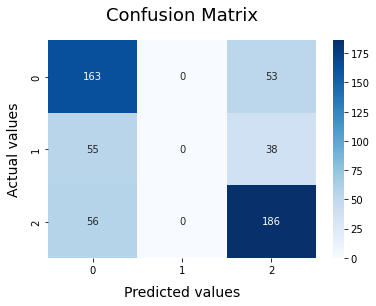

In [30]:

BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
#y_train = y_train.values.reshape(1, -1)
y_pred1 = BNBmodel.predict(X_test)


#### Linear SVM classifer:

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       216
           1       0.49      0.26      0.34        93
           2       0.64      0.79      0.71       242

    accuracy                           0.62       551
   macro avg       0.58      0.54      0.55       551
weighted avg       0.61      0.62      0.60       551



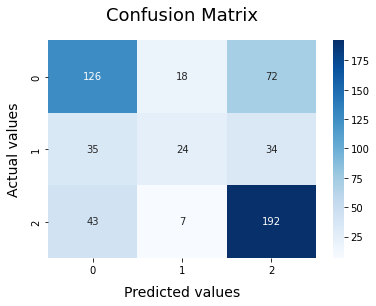

In [31]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

#### Logistic Regression:

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       216
           1       0.45      0.16      0.24        93
           2       0.61      0.82      0.70       242

    accuracy                           0.60       551
   macro avg       0.56      0.51      0.51       551
weighted avg       0.59      0.60      0.58       551



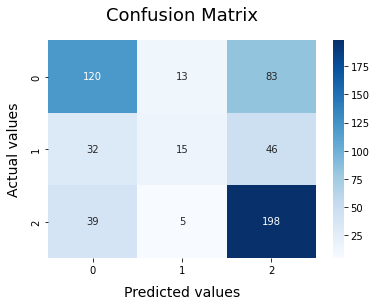

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

## Transformer Models

### Set up Data

Split data for training and testing
Use stratify to split it in a way that preserves the same proportions of examples in each class.

In [34]:
#Train test split into 80:20
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df_labelled.index.values, 
                                                   df_labelled.label.values,
                                                   test_size = 0.20,
                                                   random_state = 17,
                                                   stratify = df_labelled.label_code.values)


In [35]:
#Label the data type as training or validation based on above step
df_labelled.loc[X_train, 'data_type'] = 'train'
df_labelled.loc[X_val, 'data_type'] = 'val'



In [36]:
#Import Huggingface tokenizer for pretrained Roberta based model
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base',
                                         do_lower_case = True)

In [37]:
#Convert raw text into tokens which serves as input form for Roberta Model
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(list(df_labelled[df_labelled.data_type == 'train'].body.values),
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 455,
                                                truncation = True, 
                                                 padding = "max_length",
                                                return_tensors = "pt")
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(list(df_labelled[df_labelled.data_type == 'val'].body.values),
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 455,
                                                truncation = True, 
                                                 padding = "max_length",
                                                return_tensors = "pt")



In [38]:
import torch

In [39]:
#Create inputids, attention masks for the train and test datasets
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_labelled[df_labelled.data_type == 'train'].label_code.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_labelled[df_labelled.data_type == 'val'].label_code.values)



In [40]:
#Import roberta based model
from transformers import  RobertaForSequenceClassification

model =  RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

In [41]:
#TensorDataset creates DataLoader which provides a way to create a dataset out of the data that is already loaded into memory
#Create tensor dataset
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)



In [42]:
#create an iterator for our dataset using the torch DataLoader class
#Create data loaders for the datasets
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step



### Configure the model

In [51]:
#Set optimizer, epochs & scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 8

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/Users/prakash/Library/Python/3.8/lib/python/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
#Set seeds for reproducibility
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [53]:
#Create a function for evaluation
#To evaluate model, put it in validation mode by using .eval() 
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [54]:
#Fucntion for extarcting F1 score 
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    print(preds_flat  )
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')


In [55]:
#Function for extracting the accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Huggingface model with Finetuning

In [56]:
from tqdm import tqdm

In [57]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [58]:
#Fine tune the pre-trained model using model.train() by hugging face
#Also save the model during fine tuning
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'RobertaForSequenceClassification{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
   
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

Epoch 1:  68%|██████▊   | 47/69 [1:49:16<49:38, 135.38s/it, training_loss=0.336]


  0%|                                                   | 0/8 [2:37:01<?, ?it/s]


 Epoch {epoch}



 12%|████▋                                | 1/8 [2:48:37<19:40:24, 10117.78s/it]

[0 2 0 0 2 0 0 0 2 2 0 2 2 0 2 0 2 0 0 0 0 0 2 2 2 0 0 2 2 0 2 2 2 2 2 2 2
 2 2 0 2 0 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 0 2 2 0 0 2 2 0 0 2 0 0 0 0
 2 2 2 2 0 2 0 2 0 2 2 2 2 0 2 2 2 2 0 0 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0
 0 0 2 2 0 0 0 2 2 0 2 2 0 0 2 0 2 0 0 2 2 2 2 0 0 2 2 2 0 0 0 2 0 2 0 0 2
 2 2 2 0 2 2 2 2 0 2 2 2 0 2 0 2 2 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 0 0 2 2
 2 0 2 2 0 2 0 2 0 2 0 2 2 2 0 2 0 0 0 2 0 0 2 0 2 2 2 2 0 2 0 2 0 0 2 0 0
 0 0 0 2 2 2 2 0 0 2 0 2 0 2 0 0 2 0 2 2 0 0 2 2 0 0 2 2 2 2 0 0 2 2 0 0 0
 0 2 2 2 0 2 2 2 2 2 0 0 2 0 0 0 2 0 0 2 0 2 2 2 0 2 0 0 2 0 2 2 2 2 2 2 2
 0 2 2 2 0 2 0 0 2 2 0 2 0 0 0 2 0 2 2 2 2 2 0 0 2 2 2 2 0 2 0 0 0 2 0 0 2
 0 0 2 0 0 0 0 0 0 2 2 0 2 2 2 0 2 0 0 0 2 0 0 2 0 0 0 2 0 2 2 2 2 2 2 2 0
 2 2 0 2 2 0 2 0 2 0 0 0 2 0 0 2 0 2 0 2 2 0 0 0 2 0 2 0 2 2 2 0 2 2 0 2 0
 2 0 2 0 2 0 0 2 2 2 2 2 0 2 2 0 0 2 0 2 2 2 2 2 2 0 0 2 0 0 2 2 0 0 2 2 2
 0 0 0 0 2 2 0 0 0 0 2 2 2 0 2 2 0 0 2 0 0 0 0 2 2 0 2 0 2 0 2 2 0 0 2 2 2
 2 2 2 2 2 2 2 2 0 2 0 0 


Epoch 2:  70%|██████▉   | 48/69 [1:50:17<47:04, 134.51s/it, training_loss=0.272]


 12%|████▋                                | 1/8 [5:25:35<19:40:24, 10117.78s/it]


 Epoch {epoch}



 25%|█████████▎                           | 2/8 [5:37:04<16:51:07, 10111.20s/it]

[0 0 0 1 0 0 1 0 2 0 1 0 2 1 0 0 2 0 0 1 2 2 0 0 0 0 2 0 2 0 0 2 0 1 2 2 1
 2 2 0 0 0 0 0 2 2 2 2 0 2 2 2 2 2 2 1 0 0 1 2 0 2 1 0 2 0 0 0 0 0 0 2 1 0
 2 0 2 0 0 0 2 1 1 0 1 2 0 0 2 0 2 2 2 2 0 2 0 2 2 1 2 1 2 1 2 0 2 1 2 2 0
 0 0 0 2 0 1 2 0 0 0 2 2 0 0 0 2 2 0 0 0 0 1 1 1 0 2 2 0 2 2 0 1 2 0 0 0 0
 0 2 1 2 2 0 2 1 0 0 0 0 0 2 0 0 2 0 2 0 2 0 2 0 2 0 0 0 2 0 0 2 0 2 2 1 2
 0 0 0 0 0 2 2 0 2 2 2 0 2 2 1 0 2 1 2 2 0 2 2 0 0 2 2 2 0 0 0 2 0 2 2 1 0
 0 2 0 1 2 0 0 1 0 2 2 2 0 2 1 0 0 2 0 0 0 2 0 0 1 0 2 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 2 2 0 2 0 0 2 1 0 2 0 0 2 1 2 2 2 0 0 0 2 0 2 2 0 0 0 0 2 0
 2 2 0 0 2 2 0 0 2 0 2 2 2 2 2 0 2 0 0 2 0 0 2 2 1 1 0 2 2 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 0 2 0 0 0 0 2 2 2 2 0 0 1 2 2 2 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0
 0 2 0 0 2 2 0 0 0 0 2 2 0 1 0 1 2 0 2 0 2 0 0 2 2 0 2 2 0 2 2 0 0 2 0 0 0
 0 2 0 0 0 0 2 0 2 0 2 1 1 0 0 0 0 2 2 2 0 1 0 2 0 0 2 0 1 0 0 0 2 1 0 2 2
 0 2 0 2 2 0 2 0 1 2 2 0 2 1 0 0 2 0 0 1 1 0 0 2 1 2 2 0 0 2 1 0 2 2 0 2 2
 1 2 0 2 2 1 0 0 2 2 0 2 


Epoch 3:  70%|██████▉   | 48/69 [1:49:46<47:53, 136.82s/it, training_loss=0.142]


 25%|█████████▎                           | 2/8 [8:13:55<16:51:07, 10111.20s/it]


 Epoch {epoch}



 38%|█████████████▉                       | 3/8 [8:25:22<14:02:06, 10105.35s/it]

[2 2 2 1 0 0 0 1 0 1 2 1 1 1 1 2 2 2 1 0 1 2 1 2 2 0 2 1 0 0 2 2 2 2 2 0 0
 2 0 1 0 0 2 2 0 1 2 2 2 1 0 2 2 2 0 2 0 2 1 1 2 2 1 1 2 2 0 1 0 0 2 2 0 0
 2 2 2 1 1 0 0 1 2 2 2 2 2 2 2 1 1 2 0 1 0 2 0 2 0 0 2 1 0 2 2 2 2 0 2 2 1
 1 1 0 2 1 1 1 2 0 2 2 0 2 1 0 0 0 0 2 2 0 0 2 2 2 0 0 0 2 0 1 1 2 2 2 2 0
 0 2 2 2 2 1 2 2 0 2 0 0 2 2 2 2 2 0 0 2 0 1 0 0 2 0 1 2 2 0 0 2 0 2 2 2 0
 0 0 0 2 0 2 1 1 0 2 2 0 2 2 0 0 0 2 2 2 0 2 1 0 2 1 2 2 2 0 2 0 0 2 0 1 0
 0 2 2 2 0 1 2 0 2 2 2 0 0 2 0 0 2 0 1 2 1 2 1 2 2 2 0 0 0 2 2 2 0 0 2 2 2
 0 2 0 1 2 2 2 1 2 2 2 1 0 0 0 0 1 2 1 2 2 2 1 0 1 2 1 0 0 2 1 2 0 0 1 0 1
 2 2 0 2 1 0 1 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 2 2 2 2 1 1 2 0 0 0 2 0 1 1 2
 0 1 1 2 0 0 0 2 2 2 0 0 0 0 2 2 0 2 0 2 2 2 1 2 0 0 2 0 0 1 0 0 1 0 2 2 2
 2 2 2 0 0 2 2 2 1 1 0 2 2 1 2 0 2 0 2 2 2 2 0 2 1 0 2 0 0 1 2 0 0 0 1 2 0
 0 1 0 2 0 0 0 0 1 2 2 0 1 2 0 0 1 2 0 0 0 1 2 2 0 1 2 0 1 2 2 2 2 0 2 2 0
 1 2 1 0 0 0 0 2 1 1 0 2 0 0 1 2 2 2 2 1 2 2 2 2 0 0 1 2 2 1 2 1 1 0 0 0 1
 0 0 0 2 0 2 2 1 2 2 2 2 


Epoch 4:  70%|██████▉   | 48/69 [1:47:19<47:00, 134.31s/it, training_loss=0.100]


 38%|█████████████▌                      | 3/8 [10:59:20<14:02:06, 10105.35s/it]


 Epoch {epoch}



 50%|██████████████████                  | 4/8 [11:10:48<11:08:57, 10034.27s/it]

[0 0 0 2 2 0 0 2 1 2 2 2 2 2 2 0 0 1 1 0 2 2 1 0 0 2 0 2 2 2 0 0 2 2 0 0 0
 1 0 2 0 2 1 0 0 2 0 0 2 1 0 1 0 2 2 0 2 0 1 2 2 1 2 2 2 0 2 0 0 0 2 0 2 2
 1 2 2 0 1 1 2 0 1 0 1 0 2 2 0 1 0 2 2 2 0 0 0 0 0 2 1 2 0 2 2 2 0 0 0 0 0
 2 2 2 1 2 0 2 2 2 2 0 1 2 0 2 2 0 0 1 2 0 1 2 2 0 1 0 2 1 2 0 0 1 2 2 0 2
 2 2 0 1 1 0 2 2 0 0 2 0 1 0 2 2 0 1 1 2 0 1 2 2 0 0 1 0 2 2 2 1 1 2 2 0 2
 2 0 0 2 2 0 0 0 2 2 0 0 2 0 2 0 0 2 2 2 2 1 2 0 0 2 0 2 0 1 0 2 2 1 0 2 1
 0 0 2 0 2 2 2 1 2 2 2 2 0 2 0 2 0 0 0 2 2 2 2 2 2 0 2 0 2 2 2 2 2 1 0 2 0
 2 2 0 0 2 0 2 2 0 2 2 2 0 2 2 1 0 0 2 1 1 2 0 0 1 2 1 1 0 1 2 2 2 0 0 1 1
 1 1 0 0 2 2 0 1 0 2 0 1 2 0 2 1 1 2 2 1 1 2 2 2 0 0 1 0 0 0 1 2 2 0 2 2 0
 0 0 1 2 2 2 2 2 1 0 2 2 0 1 2 2 2 2 1 2 0 0 2 1 2 0 2 2 2 2 2 2 2 1 0 0 0
 0 0 2 2 0 0 0 2 2 0 2 2 0 2 0 0 1 0 2 0 0 2 2 0 1 0 2 0 0 1 0 2 1 2 1 2 2
 0 2 0 2 2 1 2 1 0 0 2 0 2 0 2 1 2 0 2 1 0 2 1 2 1 0 0 2 0 1 1 1 0 0 2 1 2
 1 2 0 2 1 2 2 2 2 2 0 2 0 2 1 2 1 2 2 2 2 0 0 0 2 0 0 0 2 2 2 0 0 0 1 0 0
 2 2 0 2 0 2 0 2 2 1 2 2 


Epoch 5:  70%|██████▉   | 48/69 [1:47:12<46:43, 133.49s/it, training_loss=0.196]


 50%|██████████████████                  | 4/8 [13:44:27<11:08:57, 10034.27s/it]


 Epoch {epoch}



 62%|███████████████████████▊              | 5/8 [13:55:54<8:19:24, 9988.31s/it]

[0 0 2 1 1 0 0 0 2 0 1 0 2 2 2 1 0 0 0 1 2 0 2 1 0 2 2 0 0 2 0 2 2 1 2 1 0
 0 1 2 0 1 0 1 1 0 2 2 0 2 1 2 1 2 0 2 2 2 2 2 0 2 0 2 1 0 0 0 0 0 2 0 2 2
 0 0 0 1 1 1 0 2 2 1 2 0 0 2 0 1 2 2 1 2 0 1 2 0 2 0 2 2 1 2 2 0 0 2 2 2 2
 0 1 2 1 0 2 1 2 2 1 0 2 1 2 2 2 1 1 0 2 2 0 2 1 2 0 2 0 0 2 2 2 0 1 2 0 2
 1 2 2 1 0 0 0 0 2 2 0 1 2 0 2 0 0 0 0 0 0 1 0 2 2 2 1 0 0 2 0 1 1 2 2 2 2
 2 0 2 2 2 2 2 2 0 0 2 0 1 0 1 0 2 1 2 0 0 2 0 1 1 1 0 1 2 1 1 2 0 0 2 2 0
 2 2 0 0 2 0 0 0 1 2 0 0 0 0 0 2 0 2 2 2 0 0 0 0 2 0 1 2 2 1 0 2 1 0 1 2 0
 1 1 2 0 0 0 1 0 0 1 2 2 0 2 0 0 2 2 2 0 1 0 2 2 0 0 2 2 2 0 0 2 0 2 2 0 0
 1 0 2 2 2 0 0 2 0 2 2 2 1 2 1 0 0 2 0 1 1 0 2 0 0 0 1 2 2 0 2 2 0 0 0 2 2
 2 1 0 0 2 1 2 0 2 1 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 0 1 0 0 2 0 0 1 0 0
 2 1 0 2 2 1 1 0 2 0 0 2 2 2 2 2 0 0 2 1 2 2 0 2 0 0 1 0 0 0 0 0 2 0 2 2 2
 2 1 2 2 2 1 1 1 0 2 2 2 1 2 0 2 2 0 1 1 1 0 0 1 1 0 1 0 2 1 1 1 0 2 0 2 2
 1 2 2 2 1 0 1 0 2 0 0 0 2 0 2 0 2 1 0 0 0 0 2 0 2 2 2 2 0 0 0 1 0 2 2 1 2
 0 1 2 0 0 2 1 0 0 0 0 0 


Epoch 6:  70%|██████▉   | 48/69 [1:47:37<47:14, 134.98s/it, training_loss=0.154]


 62%|███████████████████████▊              | 5/8 [16:30:14<8:19:24, 9988.31s/it]


 Epoch {epoch}



 75%|████████████████████████████▌         | 6/8 [16:41:41<5:32:28, 9974.15s/it]

[2 2 0 0 2 0 0 0 2 0 0 0 0 2 0 2 2 2 1 2 2 1 0 2 0 2 2 0 1 0 2 0 2 2 0 1 0
 0 2 0 2 2 2 0 2 2 2 0 2 0 0 2 0 0 2 0 2 0 1 2 0 2 1 0 1 2 0 0 2 2 2 1 2 2
 0 0 0 0 2 2 2 2 0 2 2 0 2 2 2 0 2 2 2 0 1 1 1 2 2 0 0 2 1 0 2 2 0 2 0 0 2
 2 0 0 1 2 2 1 2 0 0 0 0 2 1 2 2 1 2 2 2 1 2 0 2 0 2 0 0 1 2 0 0 2 2 0 1 1
 0 0 0 0 1 2 0 1 2 0 1 2 0 2 2 0 0 2 2 0 1 2 0 0 0 0 0 2 1 2 0 0 1 0 0 0 2
 2 0 0 2 2 0 1 2 0 1 2 0 0 2 0 2 0 1 0 0 2 1 0 2 0 0 2 2 0 0 0 0 2 0 0 0 2
 1 2 0 2 2 0 2 2 2 1 2 0 2 1 2 0 0 0 2 0 1 0 2 0 0 2 0 0 2 1 0 0 2 0 0 2 0
 0 0 0 2 0 0 0 2 2 2 2 2 2 2 2 1 2 2 0 0 0 0 2 0 1 1 2 1 2 2 0 0 0 0 1 2 0
 2 0 0 1 2 0 0 1 1 0 0 0 2 2 1 2 1 2 2 2 0 2 1 1 0 0 0 2 0 2 2 1 0 2 0 0 2
 2 2 0 1 0 0 2 0 1 2 2 2 2 0 2 0 2 2 0 2 2 2 0 0 0 2 0 2 2 0 2 2 1 0 0 2 2
 1 0 0 0 0 1 0 0 2 0 2 2 2 0 1 0 0 0 1 0 2 1 0 2 0 2 2 0 0 2 0 0 2 2 0 0 1
 2 2 0 2 0 2 2 2 0 2 1 1 0 2 0 0 2 0 2 0 0 0 1 2 2 2 0 1 0 2 1 1 0 2 0 0 2
 2 2 0 1 0 1 2 2 1 1 0 2 0 0 1 0 0 1 0 0 2 2 0 0 1 0 0 0 2 0 1 1 0 1 1 2 0
 2 1 0 0 0 1 2 0 1 0 0 0 


Epoch 7:  70%|██████▉   | 48/69 [1:51:38<52:37, 150.37s/it, training_loss=0.200]


 75%|████████████████████████████▌         | 6/8 [19:22:48<5:32:28, 9974.15s/it]


 Epoch {epoch}



 88%|████████████████████████████████▍    | 7/8 [19:35:16<2:48:38, 10118.23s/it]

[0 2 2 1 0 1 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 1 0 0 2 0 1 2 2 1 0 1 2 0 2 0 2
 0 0 0 0 1 2 2 0 1 1 1 2 1 2 0 1 2 2 2 0 0 2 0 0 1 1 2 0 2 2 2 0 2 2 2 0 0
 0 1 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 1 1 0 2 0 2 0 0 2 2 0 1 2 0 2 2 0 1 0
 1 0 1 2 2 1 0 0 2 0 0 0 0 0 0 0 0 2 1 0 0 0 1 2 1 0 2 1 0 0 2 2 0 2 1 2 0
 2 0 2 0 0 2 0 0 1 1 0 1 0 2 2 0 2 2 2 0 0 0 2 0 1 1 0 2 0 2 1 1 0 2 0 2 1
 0 0 0 0 0 0 2 2 1 2 1 2 0 0 0 0 0 1 0 2 0 2 0 2 0 2 2 2 2 0 1 1 2 0 0 2 2
 0 2 0 1 2 0 0 2 1 2 2 1 0 1 0 1 2 1 2 0 2 1 2 2 0 1 1 0 0 0 2 2 0 2 0 1 1
 0 2 0 2 2 1 1 0 0 1 0 0 2 2 2 0 0 0 0 0 0 2 2 2 1 2 0 1 0 2 2 0 2 1 0 2 2
 1 1 2 2 0 2 2 1 2 2 2 0 2 2 0 2 2 0 2 2 0 2 2 1 0 0 2 1 0 2 0 2 1 2 0 2 2
 2 2 0 0 0 2 2 2 0 2 2 1 1 1 1 2 0 2 2 2 1 2 2 0 2 1 0 2 0 1 2 2 2 2 1 0 0
 0 2 0 2 2 2 0 2 2 0 2 0 0 2 0 2 2 0 0 2 1 2 0 0 2 0 2 0 0 1 2 0 0 2 2 0 1
 0 2 0 1 1 2 1 0 2 1 1 2 0 0 0 2 0 2 0 2 0 1 0 2 1 1 2 0 2 2 0 0 0 1 0 1 0
 1 0 2 1 2 2 1 2 0 1 0 0 2 2 2 0 0 2 2 2 1 2 0 2 0 2 2 0 2 2 2 2 0 0 2 2 2
 0 2 2 1 2 2 2 1 0 1 2 0 


Epoch 8:  70%|██████▉   | 48/69 [1:50:31<47:47, 136.56s/it, training_loss=0.103]


 88%|████████████████████████████████▍    | 7/8 [22:13:18<2:48:38, 10118.23s/it]


 Epoch {epoch}



100%|███████████████████████████████████████| 8/8 [22:24:45<00:00, 10085.70s/it]

[2 2 2 2 1 2 0 0 1 2 2 2 0 0 0 2 2 0 1 2 2 2 2 0 0 0 2 2 1 0 0 1 0 0 0 2 2
 2 2 2 0 2 0 2 0 1 0 2 2 2 0 2 2 2 2 0 2 0 2 2 1 0 2 2 0 0 2 2 2 1 1 1 2 2
 1 0 0 0 1 0 2 1 1 2 2 0 0 2 2 2 0 1 0 2 2 1 2 2 0 0 0 0 0 2 0 1 0 1 2 0 0
 2 0 2 2 1 0 0 0 0 0 2 0 2 2 2 2 2 0 1 0 0 0 2 1 0 2 0 2 0 2 1 2 2 1 0 2 0
 1 2 2 2 1 0 2 0 0 2 2 2 2 2 1 1 0 0 0 2 2 0 1 2 0 0 0 1 2 0 2 2 2 2 1 2 2
 2 0 0 1 2 2 1 1 2 0 2 2 0 0 0 1 0 2 0 2 0 0 2 2 0 1 0 1 1 2 0 2 2 0 0 1 2
 2 2 0 0 0 0 0 2 0 2 0 2 2 2 0 1 2 2 1 0 2 1 0 2 0 2 0 1 0 2 2 2 2 1 2 0 2
 2 0 0 1 2 2 0 2 0 2 2 0 0 2 0 0 1 1 0 0 0 1 2 2 2 0 0 0 2 2 0 1 0 1 2 2 2
 2 2 2 0 2 0 1 1 0 2 1 0 0 0 0 2 0 0 1 2 2 0 1 0 2 0 2 2 1 0 0 0 0 2 0 2 2
 2 0 0 1 2 2 2 2 2 2 0 0 2 0 0 2 0 1 2 2 1 1 0 0 0 2 0 2 0 0 0 2 0 2 2 1 0
 0 0 2 2 0 1 0 0 2 2 0 1 1 0 2 1 2 2 0 2 2 0 2 2 0 1 0 2 2 1 1 2 2 2 0 2 1
 1 2 2 0 0 2 2 0 1 1 0 2 2 2 1 1 0 0 2 1 2 2 0 2 2 2 0 0 0 1 1 0 1 2 0 2 0
 2 2 2 2 2 2 2 0 0 1 2 2 2 0 0 2 2 1 2 0 2 2 2 0 0 2 0 0 0 0 0 2 1 1 1 2 1
 0 2 2 0 2 2 1 2 2 1 2 2 

In [59]:
#Calculate average training loss
loss_train_avg = loss_train_total / len(dataloader_train)
tqdm.write(f'Training loss: {loss_train_avg}')

Training loss: 0.2587098375610683


## Evaluation

In [60]:
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

100%|███████████████████████████████████████████| 18/18 [11:28<00:00, 38.27s/it]

[2 0 2 0 0 1 0 2 2 0 0 0 1 0 1 2 2 2 2 2 1 2 2 0 0 2 2 0 1 2 2 1 1 0 0 2 2
 0 1 0 0 0 0 0 0 2 2 0 0 0 2 2 1 2 1 2 2 2 2 2 2 2 1 1 2 2 2 0 2 2 0 2 0 2
 2 0 2 2 0 2 2 2 2 0 2 2 2 1 2 1 2 1 2 2 0 2 2 2 2 0 0 0 2 2 1 0 2 0 2 2 2
 1 0 2 0 1 1 2 2 0 0 0 2 1 1 0 2 1 2 2 0 2 2 1 2 0 2 0 1 0 1 2 2 2 2 0 2 0
 2 2 2 0 0 0 2 0 2 0 1 0 0 0 0 2 1 0 0 2 0 2 2 2 2 2 1 2 2 0 0 2 0 0 0 1 0
 0 2 0 0 0 2 0 2 2 2 2 0 0 2 0 2 0 2 0 2 2 0 0 0 0 2 0 0 0 0 1 0 0 2 2 2 0
 1 2 2 1 1 2 2 2 2 0 1 2 1 1 0 2 0 0 2 2 2 2 2 0 0 1 2 0 0 0 0 2 2 1 1 2 0
 0 0 2 1 0 2 0 2 0 0 0 2 0 2 0 2 1 0 0 1 1 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 1
 2 2 2 2 2 0 2 2 2 2 1 0 1 2 1 0 1 2 2 2 2 0 1 1 1 0 2 0 2 2 2 2 2 0 0 1 2
 2 2 0 2 2 2 0 0 0 2 0 2 2 2 2 2 0 0 1 2 0 2 2 0 1 0 0 1 1 2 2 0 2 0 2 0 0
 2 0 0 0 0 2 2 1 1 0 0 2 0 0 2 1 1 0 1 2 2 0 2 2 2 0 2 0 2 2 2 0 2 1 2 2 0
 0 2 1 1 0 2 2 1 2 1 0 0 0 2 2 1 2 0 2 0 0 2 2 0 0 2 1 0 2 2 1 1 0 0 2 0 2
 1 0 0 1 1 2 2 0 1 2 2 1 0 0 1 0 2 2 0 0 0 1 1 0 2 2 0 2 1 1 2 1 0 0 1 0 0
 2 1 0 2 1 1 0 0 2 0 0 0 

In [61]:
#To evaluate, we use dataloader_val:
_, predictions, true_vals = evaluate(dataloader_val)

100%|███████████████████████████████████████████| 18/18 [11:28<00:00, 38.25s/it]


In [63]:
#Accuracy on the validation set
accuracy_per_class(predictions, true_vals)

Class: Neutral
Accuracy:149/218

Class: Negative
Accuracy:62/97

Class: Positive
Accuracy:191/236



The saved model mentioned here can be found in the google drive link below:
https://drive.google.com/drive/folders/1RbdLXLmjLkNyY49M37czowGTwt--TI0p?usp=sharing

In [64]:
#Import saved model for faster evaluation and tokenizer
RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

model.load_state_dict(torch.load('RobertaForSequenceClassification8.model'))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

<All keys matched successfully>

## Huggingface model without Finetuning

#### Sentiment analysis of tweets with transformers pipeline without fine tuning:


In [65]:
# Set up data
tweets = df['body'].tolist()
true_labels = df['label_code'].to_list()


In [66]:
#Import pre trained tokenizer and model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [67]:
# Select the appropiate task for the pre trained model:

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

In [68]:
# download label mapping from the pre-trained models
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT (pytorch)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [70]:
labels

['negative', 'neutral', 'positive']

In [71]:
#Adjust the case of labels in the dictionary
label_dict =  {k.lower(): v for k, v in label_dict.items()}

In [72]:
# Run the model on input tweets 
#Count the postive, negative and Neutral tweets

neg_counter = 0
pos_counter = 0
neut_counter = 0
predictions = []

for i in tweets:     #this for-loop will take about 5-10 min to complete

  encoded_input = tokenizer(i, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  l = labels[ranking[0]]
  predictions.append(label_dict.get(l))  
  s = scores[ranking[0]]
  if l == 'positive':
      pos_counter +=1
  elif l == 'negative':
      neg_counter +=1
  else:
      neut_counter+=1

percent_pos = '%.2f' % ((pos_counter/len(tweets))*100)
percent_neg =  '%.2f' % ((neg_counter/len(tweets))*100)
percent_neut = '%.2f' % ((neut_counter/len(tweets))*100)
print(f'- in {len(tweets)} tweets, {percent_pos}% were pos , {percent_neg}% neg and {percent_neut}% were neutral.')

- in 2754 tweets, 35.51% were pos , 12.53% neg and 51.96% were neutral.


In [73]:
predictions

[0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,


In [74]:
#Function to extract metrics
import numpy as np
from datasets import load_metric
 
def compute_metrics(predictions, true_labels):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   #logits, labels = eval_pred
   #predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=true_labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=true_labels, average='macro')["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [75]:
#Compute evaluation metrics
print(compute_metrics(predictions, true_labels))

{'accuracy': 0.7901234567901234, 'f1': 0.7685946173780506}
